In [67]:

import pandas as pd

df = pd.read_parquet(r"C:\Users\kelvi\Downloads\training_data.parquet")
df.head()


,date,firm_id,macro1,macro2,price,firm1,firm2,firm3,ret
0,2020-01-01,0,Recovery,-0.226155,276.226209,0.061042,0.034084,-0.847778,0.005584
1,2020-01-01,1,Recovery,-0.226155,83.808180,-1.202923,-1.810058,0.346567,-0.022935
2,2020-01-01,2,Recovery,-0.226155,149.170163,-0.872318,-0.861621,-0.092319,-0.029843
3,2020-01-01,3,Recovery,-0.226155,48.770836,0.831588,-0.136184,-1.165729,-0.003266
4,2020-01-01,4,Recovery,-0.226155,109.207015,0.827317,-1.984357,-1.408475,0.035171


In [3]:
print(df.shape)        # should be roughly (12100, 8)
print(df.dtypes)

(12100, 9)
date       datetime64[ns]
firm_id             int64
macro1             object
macro2            float64
price             float64
firm1             float64
firm2             float64
firm3             float64
ret               float64
dtype: object


In [4]:
df['date'] = pd.to_datetime(df['date'])

df['macro1'] = df['macro1'].astype('category')

num_cols = ['macro2', 'price', 'firm1', 'firm2', 'firm3', 'ret']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')


In [5]:
print(df.isna().sum())

df = df.drop_duplicates()


date       0
firm_id    0
macro1     0
macro2     0
price      0
firm1      0
firm2      0
firm3      0
ret        0
dtype: int64


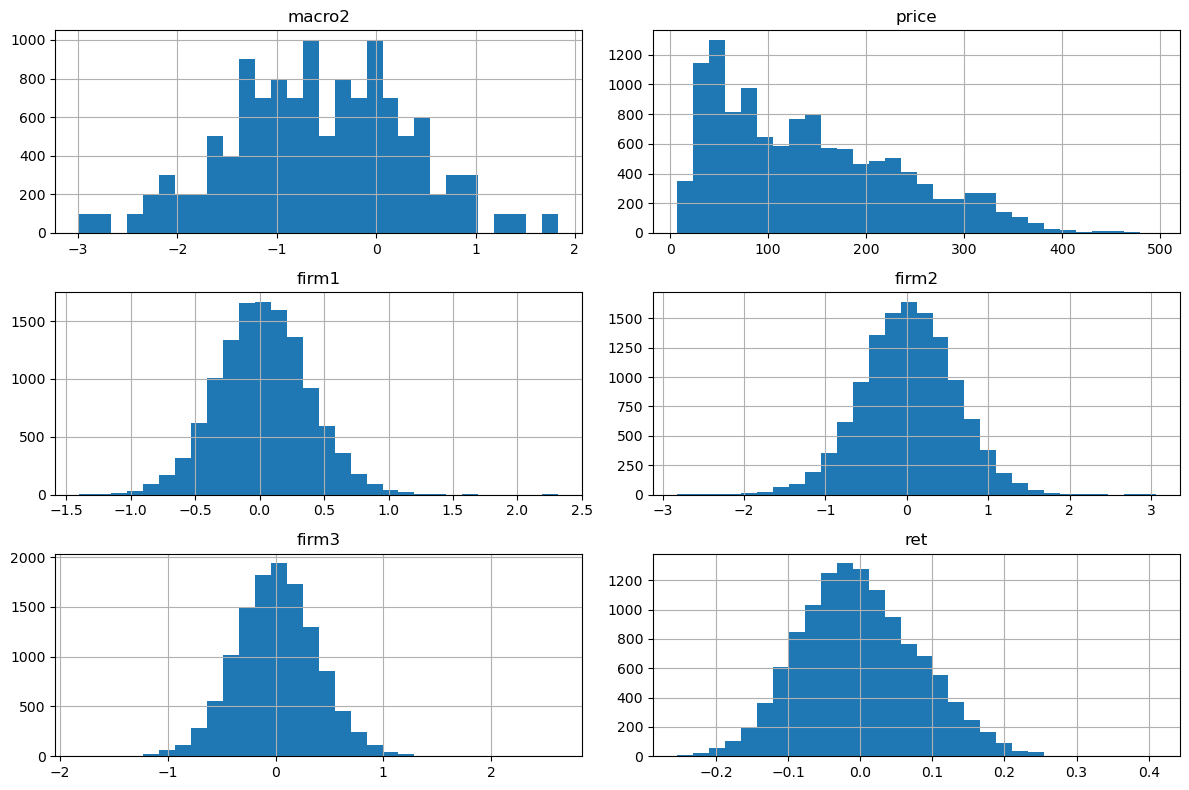

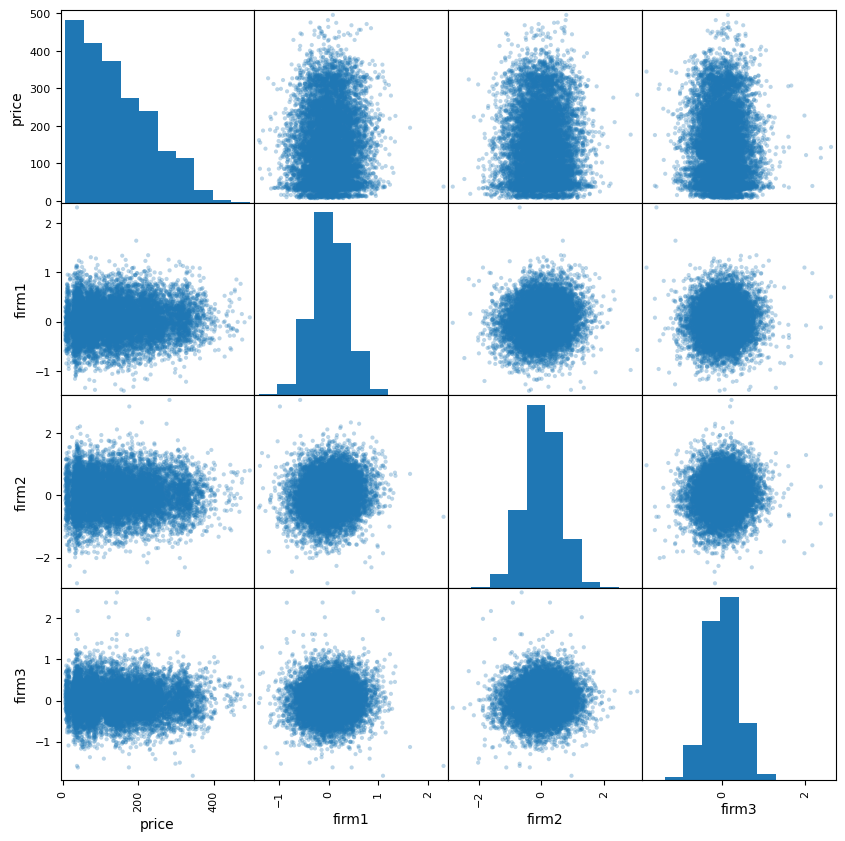

In [6]:
import matplotlib.pyplot as plt

df[num_cols].hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

pd.plotting.scatter_matrix(df[['price','firm1','firm2','firm3']], alpha=0.3, figsize=(10,10))
plt.show()


In [7]:
print(df['macro1'].value_counts())
(df.groupby('date')['macro1']
   .agg(lambda x: x.mode().iat[0])
   .value_counts()
)


macro1
Recovery       5500
Contraction    2300
Peak           1500
Expansion      1400
Trough         1400
Name: count, dtype: int64


macro1
Recovery       55
Contraction    23
Peak           15
Trough         14
Expansion      14
Name: count, dtype: int64

In [8]:
assert df.sort_values(['date','firm_id']).equals(df)

all_dates = pd.bdate_range(df['date'].min(), df['date'].max())
missing = all_dates.difference(df['date'].unique())
print("Missing trading days:", missing)


Missing trading days: DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [9]:
cutoff = df['date'].quantile(0.8)  # ~80% through time
train = df[df['date'] <= cutoff]
val   = df[df['date']  > cutoff]

print(train.shape, val.shape)


(9700, 9) (2400, 9)


In [51]:
to_lag = ['macro2', 'price', 'firm1', 'firm2', 'firm3', 'ret']
max_lag = 3  

for lag in range(1, max_lag+1):
    df[[f"{col}_lag{lag}" for col in to_lag]] = (
        df.groupby('firm_id')[to_lag]
          .shift(lag)
    )
window = 5

df['ret_rollmean_5d'] = (
    df.groupby('firm_id')['ret']
      .apply(lambda x: x.shift(1)                           
                      .rolling(window, min_periods=1)       
                      .mean()
      )
      .reset_index(level=0, drop=True)
df['volatility_5d'] = (
    df.groupby('firm_id')['log_ret']
      .apply(lambda x: x.shift(1).rolling(5, min_periods=1).std())
      .reset_index(level=0, drop=True)
)
df['ema_price_5d'] = (
    df.groupby('firm_id')['price']
      .apply(lambda x: x.shift(1)  
                       .ewm(span=5, adjust=False)
                       .mean()
      )
      .reset_index(level=0, drop=True)
)


SyntaxError: '(' was never closed (1575774242.py, line 13)

In [52]:
import numpy as np
df['log_price'] = np.log(df['price'])
df['log_ret']   = df.groupby('firm_id')['log_price'].diff()

df['f1_x_f2'] = df['firm1'] * df['firm2']
df['f1_x_f3'] = df['firm1'] * df['firm3']

for col in ['firm1','firm2','firm3','macro2']:
    df[f"{col}_sq"] = df[col]**2
    df[f"{col}_cb"] = df[col]**3

regimes = df.groupby('date')['macro1'].first().sort_index()

change_dates = regimes[regimes.shift() != regimes].index
df['days_since_regime_change'] = (
    df['date']
      .apply(lambda d: (d - change_dates[change_dates <= d].max()).days)
)
import numpy as np


df['log_price'] = np.log(df['price'])
df['log_ret']   = (
    df.groupby('firm_id')['log_price']
      .diff()
)

window = 5
df['volatility_5d'] = (
    df.groupby('firm_id')['log_ret']
      .rolling(window, min_periods=1)
      .std()
      .reset_index(level=0, drop=True)
)

df['momentum_5d'] = (
    df.groupby('firm_id')['ret']
      .rolling(window, min_periods=1)
      .sum()
      .reset_index(level=0, drop=True)
)

df['ema_price_5d'] = (
    df.groupby('firm_id')['price']
      .apply(lambda x: x.ewm(span=window, adjust=False).mean())
      .reset_index(level=0, drop=True)
)
window = 5 

df['price_rollmean'] = (
    df.groupby('firm_id')['price']
      .apply(lambda x: x.shift(1)                  
                       .rolling(window, min_periods=1)  
                       .mean()                     
      )
      .reset_index(level=0, drop=True)
)

df['price_vs_ma'] = df['price'] / df['price_rollmean'] - 1

df = df.dropna(subset=['log_ret','volatility_5d','momentum_5d','ema_price_5d'])

df = pd.get_dummies(df, columns=['macro1'], prefix='regime')
bool_cols = [c for c in df.columns if df[c].dtype == 'bool']
df[bool_cols] = df[bool_cols].astype(int)




In [53]:
df = df.dropna()  

df

,date,firm_id,macro2,price,firm1,firm2,firm3,ret,log_price,log_ret,...,volatility_5d,momentum_5d,ema_price_5d,price_rollmean,price_vs_ma,regime_Contraction,regime_Expansion,regime_Peak,regime_Recovery,regime_Trough
200,2020-01-03,0,0.091269,276.670159,0.593268,-0.049450,-0.307343,-0.016838,5.622826,0.028677,...,0.039420,0.033780,274.734751,272.537466,0.015164,0,0,0,1,0
201,2020-01-03,1,0.091269,79.840105,-0.578680,-0.512742,0.540124,0.011005,4.380026,-0.002774,...,0.030374,-0.018863,81.652988,81.935053,-0.025568,0,0,0,1,0
202,2020-01-03,2,0.091269,156.954676,0.045329,0.631473,0.037104,0.014452,5.055957,0.043572,...,0.025650,-0.002995,152.007776,149.716409,0.048347,0,0,0,1,0
203,2020-01-03,3,0.091269,52.852357,0.554693,-0.529673,0.102070,-0.026725,3.967502,0.040804,...,0.000876,-0.043033,50.568749,49.755000,0.062252,0,0,0,1,0
204,2020-01-03,4,0.091269,115.943688,0.142816,-0.160123,-0.722858,-0.008291,4.753105,-0.004505,...,0.048698,0.052718,113.065954,112.837124,0.027531,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12095,2020-04-30,95,-0.291960,243.270332,0.052227,-0.163971,-0.123048,-0.011068,5.494173,0.014323,...,0.021001,0.226199,238.605342,234.393677,0.037871,0,1,0,0,0
12096,2020-04-30,96,-0.291960,495.830892,0.087183,0.797017,0.137318,-0.032389,6.206235,0.028269,...,0.020617,0.200652,480.829794,472.908307,0.048472,0,1,0,0,0
12097,2020-04-30,97,-0.291960,112.382285,0.511944,0.890057,-0.182908,0.066233,4.721906,0.007726,...,0.029940,0.279174,113.539603,115.114697,-0.023736,0,1,0,0,0
12098,2020-04-30,98,-0.291960,38.237366,-0.086010,-0.176002,0.127472,0.039939,3.643813,-0.002731,...,0.005902,0.493808,38.019154,37.825595,0.010886,0,1,0,0,0


In [66]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_1samp

cutoff = df['date'].quantile(0.8)
train = df[df['date'] <= cutoff]
valid = df[df['date'] >  cutoff]

exclude = {'date', 'firm_id', 'ret'}
feature_cols = [c for c in df.columns if c not in exclude]
X_train, y_train = train[feature_cols].values, train['ret'].values
X_val,   y_val   = valid[feature_cols].values, valid['ret'].values

l1_ratios = np.linspace(1e-5, 1, 21)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('enet', ElasticNetCV(
        l1_ratio=l1_ratios,
        n_alphas=100,
        cv=5,
        max_iter=20000,
        random_state=42
    ))
])
pipeline.fit(X_train, y_train)

r2_val = pipeline.score(X_val, y_val)
rmse_val = np.sqrt(mean_squared_error(y_val, pipeline.predict(X_val)))
print(f"Validation R²:   {r2_val:.4f}")
print(f"Validation RMSE: {rmse_val:.6f}")

perm = permutation_importance(
    pipeline, X_val, y_val,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

importances = perm.importances
means = importances.mean(axis=1)
stds  = importances.std(axis=1)
pvals = [ttest_1samp(importances[i], 0).pvalue
         for i in range(importances.shape[0])]

feat_imp = pd.DataFrame({
    'feature':         feature_cols,
    'importance_mean': means,
    'importance_std':  stds,
    'p_value':         pvals
})
feat_imp['significant'] = feat_imp['p_value'] < 0.05
feat_imp = feat_imp.sort_values('importance_mean', ascending=False).reset_index(drop=True)

print("\nFeature Importance (ElasticNet, permutation with t-tests):")
print(feat_imp.to_string(index=False))


Validation R²:   0.7680
Validation RMSE: 0.036771

Feature Importance (ElasticNet, permutation with t-tests):
                 feature  importance_mean  importance_std      p_value  significant
                  macro2         0.448693        0.013320 7.341584e-46         True
             momentum_5d         0.303453        0.008436 1.095857e-46         True
             regime_Peak         0.059971        0.002372 2.993159e-42         True
                   firm2         0.053814        0.002942 3.496547e-38         True
                   firm1         0.033712        0.001873 5.546493e-38         True
                   firm3         0.011769        0.001590 7.058461e-27         True
             price_vs_ma         0.003672        0.000481 2.825540e-27         True
               macro2_sq         0.003489        0.000180 6.010050e-39         True
                 log_ret         0.000829        0.000176 2.303707e-21         True
               macro2_cb         0.000769        0

In [43]:
df.columns

Index(['date', 'firm_id', 'macro2', 'price', 'firm1', 'firm2', 'firm3', 'ret',
       'macro2_lag1', 'price_lag1', 'firm1_lag1', 'firm2_lag1', 'firm3_lag1',
       'ret_lag1', 'macro2_lag2', 'price_lag2', 'firm1_lag2', 'firm2_lag2',
       'firm3_lag2', 'ret_lag2', 'macro2_lag3', 'price_lag3', 'firm1_lag3',
       'firm2_lag3', 'firm3_lag3', 'ret_lag3', 'ret_rollmean', 'ret_rollstd',
       'price_rollmean', 'log_price', 'log_ret', 'price_vs_ma', 'f1_x_f2',
       'f1_x_f3', 'firm1_sq', 'firm1_cb', 'firm2_sq', 'firm2_cb', 'firm3_sq',
       'firm3_cb', 'macro2_sq', 'macro2_cb', 'days_since_regime_change',
       'volatility_5d', 'momentum_5d', 'ema_price_5d', 'regime_Contraction',
       'regime_Expansion', 'regime_Peak', 'regime_Recovery', 'regime_Trough'],
      dtype='object')

In [65]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


cutoff = df['date'].quantile(0.8)
train = df[df['date'] <= cutoff]
valid = df[df['date'] >  cutoff]

exclude = {'date', 'firm_id', 'ret'}
feature_cols = [c for c in df.columns if c not in exclude]
X_train, y_train = train[feature_cols].values, train['ret'].values
X_val,   y_val   = valid[feature_cols].values, valid['ret'].values

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2   = r2_score(y_val, y_pred)

print(f"Validation RMSE: {rmse:.6f}")
print(f"Validation R²:   {r2:.4f}")

booster = xgb_model.get_booster()
orig_importance = booster.get_score(importance_type='weight')
orig_imp_array = np.array([orig_importance.get(f'f{idx}', 0) 
                           for idx in range(len(feature_cols))])

n_boot = 100
boot_importances = np.zeros((len(feature_cols), n_boot))

for b in range(n_boot):
    idxs = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_boot, y_boot = X_train[idxs], y_train[idxs]
    model_b = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=42
    )
    model_b.fit(X_boot, y_boot)
    imp_b = model_b.get_booster().get_score(importance_type='weight')
    for i in range(len(feature_cols)):
        boot_importances[i, b] = imp_b.get(f'f{i}', 0)

p_values = (boot_importances <= 0).mean(axis=1)

feat_imp_xgb = pd.DataFrame({
    'feature':         feature_cols,
    'orig_importance': orig_imp_array,
    'boot_mean':       boot_importances.mean(axis=1),
    'boot_std':        boot_importances.std(axis=1),
    'p_value':         p_values
})
feat_imp_xgb['significant'] = feat_imp_xgb['p_value'] < 0.05
feat_imp_xgb = feat_imp_xgb.sort_values('orig_importance', ascending=False).reset_index(drop=True)

print("\nFeature Importance (XGBoost split counts with bootstrap p-values):")
print(feat_imp_xgb.to_string(index=False))


Validation RMSE: 0.036518
Validation R²:   0.7712

Feature Importance (XGBoost split counts with bootstrap p-values):
                 feature  orig_importance  boot_mean  boot_std  p_value  significant
                  macro2            239.0     207.75 11.322875     0.00         True
                   firm2            181.0     157.42 10.012173     0.00         True
             momentum_5d            167.0     166.44  9.139278     0.00         True
days_since_regime_change            117.0     106.79  9.057919     0.00         True
                   firm1            108.0     114.47  8.445656     0.00         True
                   firm3             96.0     104.22  8.537658     0.00         True
               macro2_sq             65.0      64.01  8.016851     0.00         True
                 f1_x_f2             57.0      60.23  7.816463     0.00         True
                 log_ret             53.0      56.97  8.290302     0.00         True
                firm2_sq        

In [77]:
import pandas as pd
import numpy as np
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

# 1. Define the feature‐engineering transformer
class FinancialFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, window=5):
        self.window = window
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(['firm_id','date'])
        
        # log‐price & log‐return
        df['log_price'] = np.log(df['price'])
        df['log_ret']   = df.groupby('firm_id')['log_price']\
                              .shift(1).diff()
        
        # rolling volatility, momentum, EMA, price_vs_ma
        w = self.window
        df['volatility_{}d'.format(w)] = df.groupby('firm_id')['log_ret']\
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).std())
        df['momentum_{}d'.format(w)]   = df.groupby('firm_id')['ret']\
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).sum())
        df['ema_price_{}d'.format(w)]  = df.groupby('firm_id')['price']\
            .transform(lambda s: s.shift(1).ewm(span=w, adjust=False).mean())
        df['price_rollmean'] = df.groupby('firm_id')['price']\
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
        df['price_vs_ma']    = df['price'] / df['price_rollmean'] - 1
        
        # interactions & polys
        df['f1_x_f2'] = df['firm1'] * df['firm2']
        df['f1_x_f3'] = df['firm1'] * df['firm3']
        for col in ['firm1','firm2','firm3','macro2']:
            df[f'{col}_sq'] = df[col]**2
            df[f'{col}_cb'] = df[col]**3
        
        regimes     = df.groupby('date')['macro1'].first().sort_index()
        change_idx  = regimes[regimes.shift() != regimes].index
        df['days_since_regime_change'] = df['date']\
            .apply(lambda d: (d - change_idx[change_idx <= d].max()).days)
        
        # one‐hot encode
        df = pd.get_dummies(df, columns=['macro1'], prefix='regime', dtype=int)
        
        exclude = {'date','firm_id','ret'}
        return df[[c for c in df.columns if c not in exclude]]

df = pd.read_parquet(r"C:\Users\kelvi\Downloads\training_data.parquet")

fe       = FinancialFeatureEngineer(window=5)
feat_df  = fe.transform(raw_df)
feat_df['date']    = raw_df['date']
feat_df['firm_id'] = raw_df['firm_id']
feat_df['ret']     = raw_df['ret']

feat_df = feat_df.dropna()

cutoff   = pd.to_datetime(feat_df['date']).quantile(0.8)
train    = feat_df[feat_df['date'] <= cutoff]
valid    = feat_df[feat_df['date']  > cutoff]
X_train  = train.drop(columns=['date','firm_id','ret'])
y_train  = train['ret']
X_valid  = valid.drop(columns=['date','firm_id','ret'])
y_valid  = valid['ret']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model',   ElasticNetCV(
                    l1_ratio=np.linspace(1e-5,1,21),
                    n_alphas=100,
                    cv=5,
                    max_iter=20000,
                    random_state=42
               ))
])
pipeline.fit(X_train, y_train)

y_pred   = pipeline.predict(X_valid)
rmse_val = np.sqrt(mean_squared_error(y_valid, y_pred))
r2_val   = pipeline.score(X_valid, y_valid)
print(f"Validation RMSE: {rmse_val:.6f}")
print(f"Validation R²:   {r2_val:.4f}")
perm       = permutation_importance(
    pipeline, X_val, y_val,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)
importances = perm.importances
means      = importances.mean(axis=1)
stds       = importances.std(axis=1)
pvals      = [ttest_1samp(importances[i], 0).pvalue
              for i in range(importances.shape[0])]

coefs     = pipeline.named_steps['model'].coef_
abs_coefs = np.abs(coefs)

feat_imp = pd.DataFrame({
    'feature':         feature_cols,
    'coef':            coefs,
    'abs_coef':        abs_coefs,
    'perm_mean':       means,
    'perm_std':        stds,
    'perm_p_value':    pvals
})
feat_imp['perm_significant'] = feat_imp['perm_p_value'] < 0.05

feat_imp = feat_imp.sort_values('perm_mean', ascending=False).reset_index(drop=True)

print("\nFeature Importance Summary:")
print(feat_imp.to_string(index=False))
with open("financial_model_pipeline.pkl", "wb") as f:
    pickle.dump((fe, pipeline), f)

with open("financial_model_pipeline.pkl", "rb") as f:
    fe_loaded, model_loaded = pickle.load(f)




Validation RMSE: 0.041033
Validation R²:   0.7111


C:\Users\kelvi\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Feature Importance Summary:
                 feature      coef  abs_coef     perm_mean  perm_std  perm_p_value  perm_significant
            ema_price_5d  0.003014  0.003014  1.780076e+01  0.339431  1.967295e-51              True
          price_rollmean -0.013612  0.013612  1.763329e+01  0.400484  3.127284e-49              True
                  macro2  0.059619  0.059619  7.420482e-01  0.048131  4.888805e-36              True
                   firm1  0.010830  0.010830  6.088179e-02  0.011921  2.517686e-22              True
             regime_Peak  0.003175  0.003175  4.758244e-02  0.007930  2.711072e-24              True
                 f1_x_f2 -0.000594  0.000594  4.014227e-02  0.015716  3.069320e-14              True
                   firm3  0.009788  0.009788  3.932395e-02  0.007683  2.362244e-22              True
                firm2_sq  0.004643  0.004643  3.541659e-02  0.048928  5.273290e-04              True
                   firm2  0.013192  0.013192  2.704224e-02  0.

C:\Users\kelvi\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [80]:
import pandas as pd
import numpy as np
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

class FinancialFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, window=5):
        self.window = window
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(['firm_id','date'])
        w = self.window

        df['log_price'] = np.log(df['price'])
        df['log_ret']   = df.groupby('firm_id')['log_price'].shift(1).diff()

        df[f'volatility_{w}d'] = df.groupby('firm_id')['log_ret']\
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).std())
        df[f'momentum_{w}d']   = df.groupby('firm_id')['ret']\
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).sum())
        df[f'ema_price_{w}d']  = df.groupby('firm_id')['price']\
            .transform(lambda s: s.shift(1).ewm(span=w, adjust=False).mean())
        df['price_rollmean']   = df.groupby('firm_id')['price']\
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
        df['price_vs_ma']      = df['price'] / df['price_rollmean'] - 1

        df['f1_x_f2'] = df['firm1'] * df['firm2']
        df['f1_x_f3'] = df['firm1'] * df['firm3']
        for col in ['firm1','firm2','firm3','macro2']:
            df[f'{col}_sq'] = df[col]**2
            df[f'{col}_cb'] = df[col]**3

        regimes    = df.groupby('date')['macro1'].first().sort_index()
        change_idx = regimes[regimes.shift() != regimes].index
        df['days_since_regime_change'] = df['date']\
            .apply(lambda d: (d - change_idx[change_idx <= d].max()).days)

        df = pd.get_dummies(df, columns=['macro1'], prefix='regime', dtype=int)

        exclude = {'date','firm_id','ret'}
        return df[[c for c in df.columns if c not in exclude]]

raw_df  = pd.read_parquet(r"C:\Users\kelvi\Downloads\training_data.parquet")
fe      = FinancialFeatureEngineer(window=5)
feat_df = fe.transform(raw_df)
feat_df[['date','firm_id','ret']] = raw_df[['date','firm_id','ret']]
feat_df = feat_df.dropna()

cutoff       = pd.to_datetime(feat_df['date']).quantile(0.8)
train, valid = feat_df[feat_df['date'] <= cutoff], feat_df[feat_df['date'] > cutoff]
feature_cols = [c for c in feat_df.columns if c not in ['date','firm_id','ret']]
X_train_df   = train[feature_cols]
y_train      = train['ret'].values
X_valid_df   = valid[feature_cols]
y_valid      = valid['ret'].values
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # optional
    ('model',  XGBRegressor(
                   n_estimators=100,
                   max_depth=4,
                   learning_rate=0.1,
                   subsample=1.0,
                   colsample_bytree=1.0,
                   random_state=42,
                   n_jobs=-1,
                   objective='reg:squarederror'
               ))
])
pipeline.fit(X_train_df, y_train)

y_pred = pipeline.predict(X_valid_df)
rmse   = np.sqrt(mean_squared_error(y_valid, y_pred))
r2     = r2_score(y_valid, y_pred)
print(f"Validation RMSE: {rmse:.6f}")
print(f"Validation R²:   {r2:.4f}")

xgb_model       = pipeline.named_steps['model']
booster         = xgb_model.get_booster()
orig_imp_dict   = booster.get_score(importance_type='weight')
orig_imp_array  = np.array([orig_imp_dict.get(f"f{i}", 0) for i in range(len(feature_cols))])

X_train = X_train_df.values
n_boot  = 100
boot_imps = np.zeros((len(feature_cols), n_boot))

for b in range(n_boot):
    idxs = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
    Xb, yb = X_train[idxs], y_train[idxs]
    mb = XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=42
    )
    mb.fit(Xb, yb)
    imp_b = mb.get_booster().get_score(importance_type='weight')
    for i in range(len(feature_cols)):
        boot_imps[i, b] = imp_b.get(f"f{i}", 0)

p_values = (boot_imps <= 0).mean(axis=1)

feat_imp_xgb = pd.DataFrame({
    'feature':         feature_cols,
    'orig_importance': orig_imp_array,
    'boot_mean':       boot_imps.mean(axis=1),
    'boot_std':        boot_imps.std(axis=1),
    'p_value':         p_values
})
feat_imp_xgb['significant'] = feat_imp_xgb['p_value'] < 0.05
feat_imp_xgb = feat_imp_xgb.sort_values('orig_importance', ascending=False).reset_index(drop=True)

print("\nXGBoost Feature Importance with Bootstrap p-values:")
print(feat_imp_xgb.to_string(index=False))

with open("xgb_model_pipeline.pkl", "wb") as f:
    pickle.dump((fe, pipeline), f)

with open("xgb_model_pipeline.pkl", "rb") as f:
    fe_loaded, model_loaded = pickle.load(f)



Validation RMSE: 0.041429
Validation R²:   0.7055

XGBoost Feature Importance with Bootstrap p-values:
                 feature  orig_importance  boot_mean  boot_std  p_value  significant
                  macro2            236.0     197.63 11.721480     0.00         True
                   firm2            172.0     166.68  9.949754     0.00         True
days_since_regime_change            121.0     108.37  8.932698     0.00         True
             momentum_5d            117.0     114.84  9.179020     0.00         True
                   firm1            116.0     123.72  9.043318     0.00         True
                   firm3            108.0     116.83  8.334333     0.00         True
               macro2_sq             83.0      75.03  8.060341     0.00         True
                 f1_x_f2             60.0      57.43  8.835446     0.00         True
           regime_Trough             57.0      47.62  4.544843     0.00         True
           volatility_5d             56.0      